# Project description

The online store Ice sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.
In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.
The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

# Data description

- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import math

## Data Preparetion

In [2]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
data.columns = data.columns.str.lower()

In [6]:
data['user_score'].replace('tbd', 0.0, inplace=True)

I replaced all tbd values in user_score column with 0.0 to be able work with the data. I checked if there is any values with 0.0 before replacing as they could have been confused with each other.

In [7]:
data['user_score'] = data['user_score'].astype('float')

In [8]:
data.isna().sum() *100 / len(data) 

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

I will drop the missing values in year_of_release column to be able to change the data type to integer. I will be droppping only 1.6% of the value which isn't significant. 

In [9]:
data.dropna(subset= ['year_of_release'], inplace=True)

In [10]:
data['year_of_release'] = data['year_of_release'].astype(int)

Most of the missing values are in either critic_score, user_score, or rating column. It could be due to having no score or rating which is why I will leave them as blank.

In [11]:
data.dropna(subset= ['name','genre'], inplace=True)

In [12]:
data['rating'].fillna('unknown', inplace=True)

In [13]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


## Analyzing the data

In [15]:
year_size = data.groupby('year_of_release').agg('size').div(len(data)) * 100

<AxesSubplot:title={'center':'Percentage of Games Released Per Year'}, xlabel='year_of_release'>

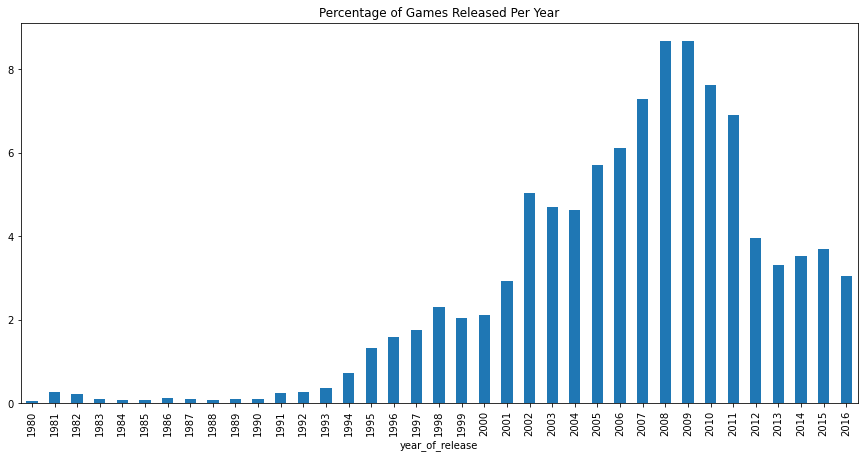

In [16]:
year_size.plot(kind='bar', figsize=(15,7), title='Percentage of Games Released Per Year')

Most of the data from 2000 and before are not significant. 

In [17]:
data\
    .pivot_table(index='platform',values='total_sales', aggfunc='sum')\
    .sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [18]:
data_platform = data.query('platform == "PS2" or platform == "X360" or platform == "PS3" or platform == "Wii"')

data_platform.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='size')

year_of_release,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,
PS2,82.0,185.0,280.0,256.0,259.0,260.0,259.0,214.0,191.0,96.0,38.0,7.0,NaN,NaN,NaN,NaN,NaN
PS3,NaN,NaN,NaN,NaN,NaN,NaN,27.0,90.0,138.0,162.0,181.0,215.0,148.0,126.0,108.0,73.0,38.0
Wii,NaN,NaN,NaN,NaN,NaN,NaN,44.0,185.0,282.0,325.0,253.0,143.0,31.0,12.0,6.0,4.0,1.0
X360,NaN,NaN,NaN,NaN,NaN,18.0,93.0,123.0,146.0,172.0,182.0,206.0,106.0,75.0,63.0,35.0,13.0


PS2 was the most popular platform until PS3 came out, after that the sales has started droppping. In average, it takes about 5 years for a platform's popularity to fade away. Once the new versions come out, the older versions are not preferred anymore.

I will work with data from 2015 because the data from 2016 aren't complete and I need recent data to build a prognosis for 2017. 

In [19]:
data_2015 = data.query('year_of_release == 2015')

In [20]:
data_2015\
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')\
    .sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS4,118.90
XOne,60.14
3DS,27.78
PS3,16.82
WiiU,16.35
X360,11.96
PC,8.52
PSV,6.25
Wii,1.14


In 2015, the platforms leading in sales were PS4, XOne, 3DS, PS3, and WiiU. The ones shrinking in sales were Wii and PSP which were replaced by new versions. 

<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

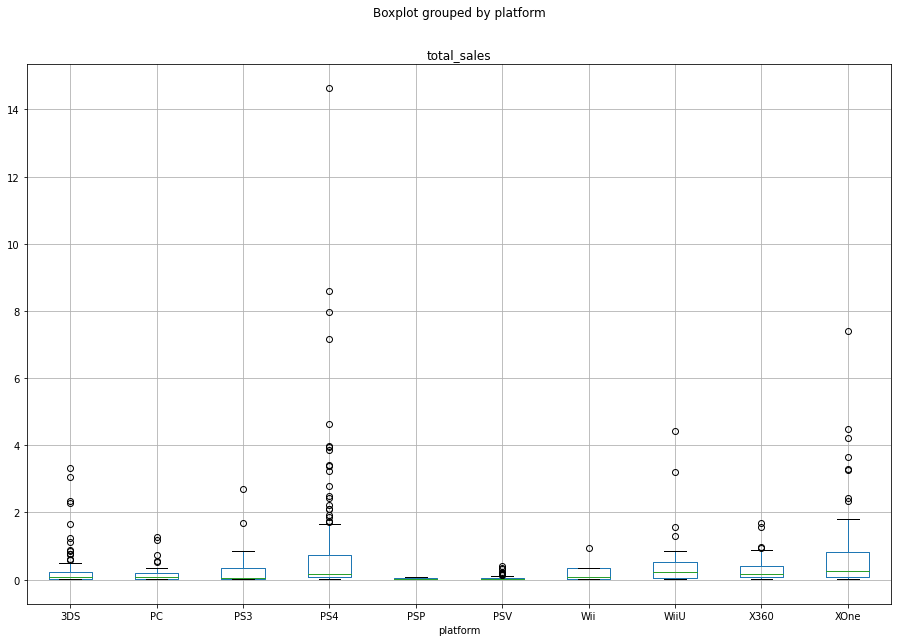

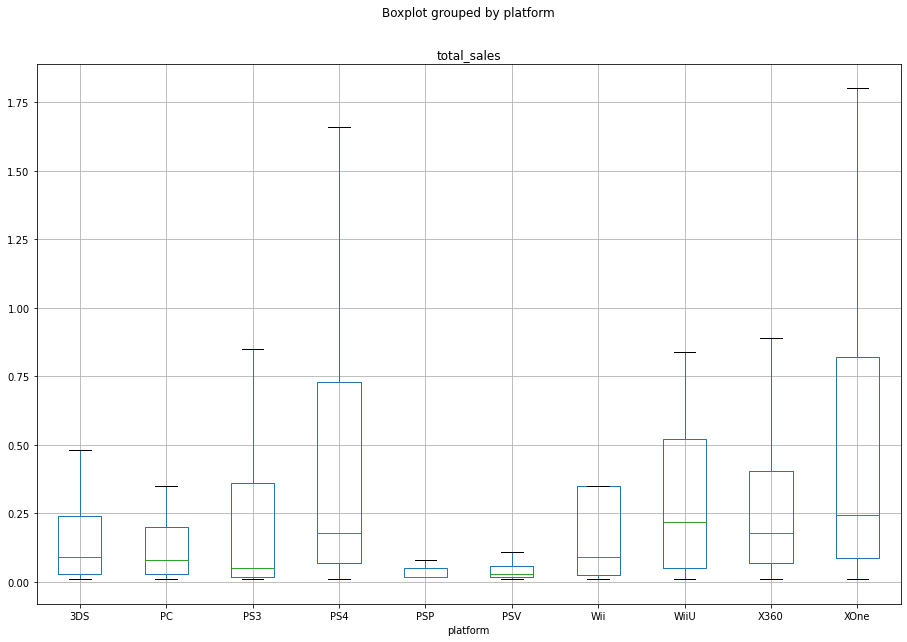

In [21]:
data_2015.boxplot(by='platform', column=['total_sales'], figsize=(15,10))
data_2015.boxplot(by='platform', column=['total_sales'], figsize=(15,10), showfliers=False)

The difference in sales between leading and shrinking platforms are significant. 

0.4123418699511164

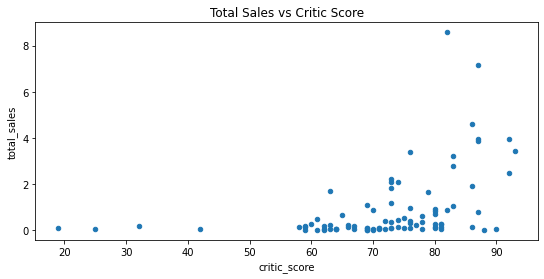

In [22]:
data_2015_ps4 = data_2015.query('platform == "PS4"')
data_2015_ps4.plot(kind='scatter', 
          x='critic_score', 
          y='total_sales', 
          figsize=(9,4), 
          title='Total Sales vs Critic Score'
         )

data_2015_ps4['critic_score'].corr(data_2015_ps4['total_sales'])

0.024637157374715373

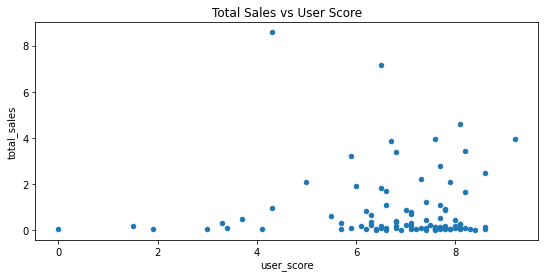

In [23]:
data_2015_ps4.plot(kind='scatter', 
          x='user_score', 
          y='total_sales', 
          figsize=(9,4), 
          title='Total Sales vs User Score'
         )

data_2015_ps4['user_score'].corr(data_2015_ps4['total_sales'])

There is a positive correlation between reviews and sales of PS4 platform. 

In [24]:
data_2015.pivot_table(index='platform', columns='name', values='total_sales', aggfunc='sum')

name,Fire Emblem Fates,3rd Super Robot Wars Z: Tengoku-Hen,7 Roses: A Darkness Rises,7th Dragon III Code: VFD,A Good Librarian Like a Good Shepherd: Library Party,Abunai: Koi no Sousa Shitsu,Act of Aggression,Adventure Time: Finn & Jake Investigations,Aikatsu! My No.1 Stage!,Airship Q,...,Xenoblade Chronicles X,Yakuza Zero: The Place of Oath,YoKai Watch Dance: Just Dance Special Version,Yokai Watch Busters,Yomawari,Yoru no Nai Kuni,Yoshi's Woolly World,Yowamushi Pedal,Yuki Yuna is a Hero: Memory of the Forest,Zombie Army Trilogy
platform,,,,,,,,,,,,,,,,,,,,,
3DS,1.67,NaN,NaN,0.16,NaN,NaN,NaN,0.09,0.08,NaN,...,NaN,NaN,NaN,2.29,NaN,NaN,NaN,0.04,NaN,NaN
PC,NaN,NaN,0.02,NaN,NaN,NaN,0.01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS3,NaN,0.15,NaN,NaN,NaN,NaN,NaN,0.08,NaN,NaN,...,NaN,0.25,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,NaN,NaN,...,NaN,0.17,NaN,NaN,NaN,0.08,NaN,NaN,NaN,0.20
PSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PSV,NaN,0.19,NaN,NaN,0.03,0.02,NaN,NaN,NaN,0.03,...,NaN,NaN,NaN,NaN,0.11,0.08,NaN,NaN,0.04,NaN
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WiiU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,...,0.84,NaN,0.03,NaN,NaN,NaN,1.3,NaN,NaN,NaN
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mostly one game has sales in only one platform. When there's more than one platform selling the same game, the sales are close to each other. 

In [25]:
data_2015.groupby('genre').agg('size')\
    .sort_values(ascending=False)

genre
Action          253
Role-Playing     78
Sports           59
Adventure        54
Misc             39
Shooter          34
Fighting         21
Racing           18
Strategy         16
Simulation       15
Platform         13
Puzzle            6
dtype: int64

In [26]:
data_2015\
    .pivot_table(index='genre', values='total_sales')\
    .sort_values(by='total_sales', ascending=False)

,total_sales
genre,
Shooter,1.985588
Sports,0.692203
Role-Playing,0.482564
Platform,0.465385
Racing,0.448333
Simulation,0.377333
Fighting,0.376190
Misc,0.296667
Action,0.284664


<AxesSubplot:title={'center':'total_sales'}, xlabel='genre'>

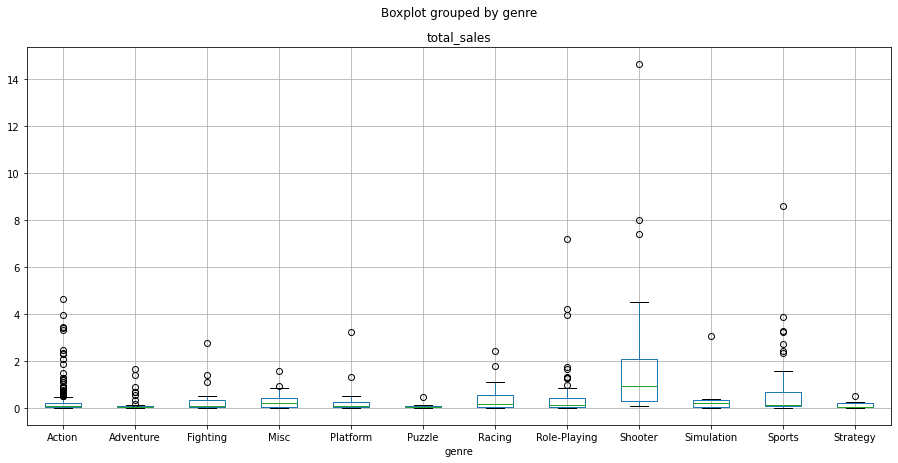

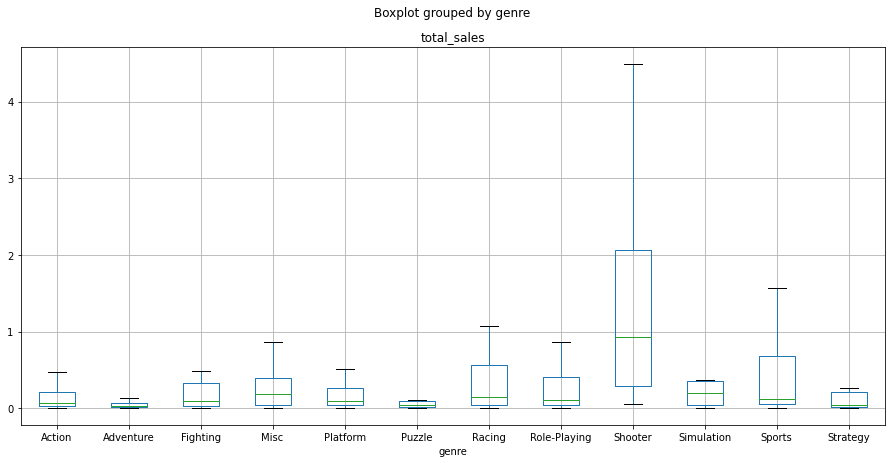

In [27]:
data_2015.boxplot(by='genre', column=['total_sales'], figsize=(15,7))
data_2015.boxplot(by='genre', column=['total_sales'], figsize=(15,7), showfliers=False)

In 2015, shooter games had more sales with an average of $1.98M.

## Creating A User Profile For Each Region

In [28]:
data_2015.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
platform,,,
3DS,5.06,15.52,6.17
PC,5.57,0.00,2.36
PS3,6.04,3.67,4.99
PS4,51.76,6.31,42.37
PSP,0.00,0.12,0.00
PSV,0.69,4.85,0.39
Wii,0.62,0.00,0.43
WiiU,5.01,3.45,6.76
X360,3.50,0.00,7.36


The top five platforms in Europe are PS4, XOne, PS3, PC, and 3DS.

The top five platforms in North America are PS4, XOne, X360, WiiU, and 3DS.

The top five platforms in Japan are 3DS, PS4, PSV, PS3, and WiiU.

In [29]:
data_2015.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
genre,,,
Action,24.14,15.98,24.39
Adventure,3.35,1.04,2.89
Fighting,2.38,0.79,3.70
Misc,3.60,2.15,4.82
Platform,1.81,1.31,2.49
Puzzle,0.12,0.52,0.06
Racing,4.75,0.28,2.09
Role-Playing,12.93,6.80,13.93
Shooter,24.38,2.73,31.94


The top five genres in Europe are shooter, action, sports, role-playing, and racing.

The top five genres in North America are shooter, action, sports, role-playing, and misc.

The top five genres in Japan are action, role-playing, shooter, misc, and simulation. 

<AxesSubplot:ylabel='na_sales'>

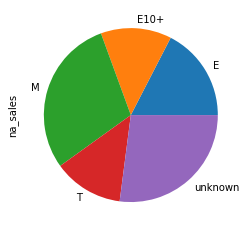

In [30]:
data_2015\
    .groupby('rating')['na_sales'].sum()\
    .plot(kind='pie')

<AxesSubplot:ylabel='eu_sales'>

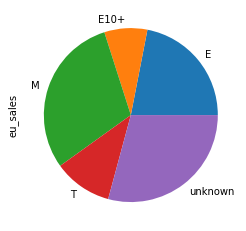

In [31]:
data_2015\
    .groupby('rating')['eu_sales'].sum()\
    .plot(kind='pie')

<AxesSubplot:ylabel='jp_sales'>

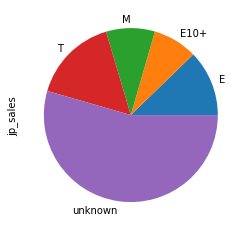

In [32]:
data_2015\
    .groupby('rating')['jp_sales'].sum()\
    .plot(kind='pie')

ESRB ratings affect sales in individual regions. Games with no rating make up a huge part of the data. Mature and E rated games have more sales in North America and Europe. In Japan, most of the sales come from games with no ESRB rating. It could be due to using another rating system in this region.

## Testing Hypotheses

H0:Average user ratings of the Xbox One and PC platforms are the same.

H1:Average user ratings of the Xbox One and PC platforms are not the same.

In [33]:
xone = data_2015.query('platform == "XOne"')
xone_ave_rating = xone.pivot_table(index='name', values='user_score')

In [34]:
pc = data_2015.query('platform == "PC"')
pc_ave_rating = pc.pivot_table(index='name', values='user_score')

In [35]:
alpha = 0.05

results = st.ttest_ind(xone_ave_rating, pc_ave_rating)

print('p_value:', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

p_value: [0.72155659]
We cannot reject the null hypothesis.


H0:Average user ratings for the Action and Sports genres are not different.

H1:Average user ratings for the Action and Sports genres are different.

In [36]:
action = data_2015.query('genre == "Action"')
action_ave_rating = action.pivot_table(index='name', values='user_score')

In [37]:
sports = data_2015.query('genre == "Sports"')
sports_ave_rating = sports.pivot_table(index='name', values='user_score')

In [38]:
alpha = 0.05

results = st.ttest_ind(action_ave_rating, sports_ave_rating)

print('p_value:', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

p_value: [0.16411812]
We cannot reject the null hypothesis.


## Conclusion

To prepare the data, columnn names were made lowercase and the data were converted to required types. Missing data were either dropped or replaced with appropriate data. TBD values were replaced with 0.0. Total sales column was created by adding all sales values from each regions. To analyze the data, the platforms with greatest sales were found and a distribution was built. Platforms that used to be popular tend to fade away overtime or when a new version comes out. To biuld a prognosis for 2017, data from 2015 was chosen as the data from 2016 aren't complete. Rest of the data was disregarded. In 2015, the platforms leading in sales were PS4, XOne, 3DS, PS3, and WiiU whereas  Wii and PSP were fading away. A box plot for the global sales of all games, broken down by platform was built and the differences in sales was found to be significant. For PS4, the correlation between critic score and total sales was found to be 0.412 and The correlation between user score and total sales was found to be 0.025. Shooter games were more profitable in 2015 with an average of $1.98M . For each region, top five platforms and top five genres were determined. ESRB ratings have an affect on sales in individual regions.In Europe and North America, M and E rated games have more sales. In Japan, games with no rating bring in more revenue which could be due to having a different raating system. Two hypotheses were tested with ttest_ind as they are independent of each other. Alpha value was was chosen to be 0.05. It was found that average user ratings of the Xbox One and PC platforms are the same and average user ratings for the Action and Sports genres are not different.